In [1]:
from collections import defaultdict
import operator
import os
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pecanpy as pp
import scipy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_geometric.nn as gnn
from umap import UMAP

In [2]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [3]:
# Data params
directed = True
disease_type = 'SCZ'
def get_dirs(disease_type):
    model_dir = f'./models/{disease_type}'
    results_dir = f'./results/{disease_type}'
    return model_dir, results_dir
model_dir, results_dir = get_dirs(disease_type)

# Run params
runs = 10  # Number of runs
folds = 5  # Folds per run
run, fold = 0, 0  # Current stat
percentile = 0  # Data filtering
# RW params  # NEW
param_grid = {
    'dim': [8, 16, 32, 64, 128],
    'num_walks': [10, 20, 30, 40],
    'walk_length': [10, 20, 40, 80],
}
np.random.seed(42)
dim_list = np.random.choice(param_grid['dim'], runs)
num_walks_list = np.random.choice(param_grid['num_walks'], runs)
walk_length_list = np.random.choice(param_grid['walk_length'], runs)

# Dataset

In [4]:
def get_cells(disease_type, directed=False):
    cell_fnames = np.array(os.listdir(f'./data/psychAD_merged_GRN_0.2_0.2/{disease_type}'))
    cell_types = [ct.split('.')[0] for ct in cell_fnames]
    cell_fname = cell_fnames[0]
    cell_type = cell_fname.split('.')[0]
    
    return (cell_fnames, cell_types), (cell_fname, cell_type)

(cell_fnames, cell_types), (cell_fname, cell_type) = get_cells(disease_type, directed=directed)
for ct in cell_types:
    print(ct) if ct != cell_type else print(f'--{ct}')

--Astrocyte
Endothelial
GABAergic neuron
GABAergic PVALB interneuron
GABAergic SST interneuron
GABAergic VIP interneuron
Glutamatergic neuron
Microglia
Mural
Oligodendrocyte
OPC


Generating Astrocyte graph...
Filtering data...


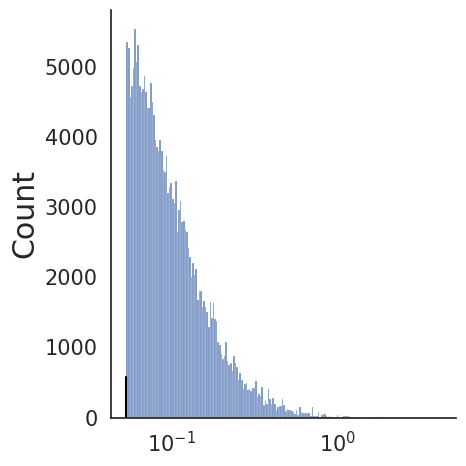

In [5]:
def get_data(cell_fname, method='scGRNom', directed=True, output='_elist.edg'):
    # Read data
    tftg = pd.read_csv(f'./data/psychAD_merged_GRN_0.2_0.2/{disease_type}/{cell_fname}', sep='\t', low_memory=False)  # low_memory avoids loading warning
    # Filter to one method (SCENIC, scGRNom)
    if method is not None:
        tftg = tftg.iloc[np.argwhere((tftg['method']==method).to_numpy()).flatten(), :]
    # Remove all zero weights
    tftg = tftg.iloc[np.argwhere(tftg['edgeWeight'].to_numpy() != 0).flatten(), :]
    # Set all nonzero weights to one
    if method is None:
        tftg[['edgeWeight']] = 1.
    # Filter to targets
    tftg = tftg[['TF', 'TG', 'edgeWeight']]
    # Make undirected
    tg_genes = np.unique(tftg['TG'])
    if not directed:
        tftg = pd.DataFrame(
            np.concatenate([tftg[['TF', 'TG', 'edgeWeight']].to_numpy(), tftg[['TG', 'TF', 'edgeWeight']].to_numpy()]))
    # Save file
    tftg.to_csv(output, sep='\t', header=None, index=None)
    
    return tg_genes

def get_labels(genes, disease_type, gene_filter=[]):
    # Get labels
    disDict = {'AD': 'Alzheimer', 'SCZ': 'Schizophrenia'}
    meta = pd.read_csv(f'./data/training_labels_NPS_disgenet_manual/{disDict[disease_type]}.disgenenet_manual.txt', index_col=None, sep='\t')
    positive_genes = meta.to_numpy().flatten()
    labels = np.array([('pos' if (g in positive_genes) else 'neg') if (g in gene_filter) else 'unk' for g in genes])

    return labels

def filter_elist():
    elist = pd.read_csv('_elist.edg', sep='\t', header=None)

    # Eliminate low-value data
    reg_threshold = np.percentile(elist.iloc[:, 2].to_numpy().flatten(), percentile)
    elist = elist.iloc[np.argwhere((elist.iloc[:, 2] >= reg_threshold).to_numpy()).flatten(), :]
    elist.to_csv('_elist.edg', sep='\t', header=None, index=None)
    
    return reg_threshold

print(f'Generating {cell_type} graph...')
# Load data
tg_genes = get_data(cell_fname, directed=directed)

# Plot approximate distribution
elist = pd.read_csv('_elist.edg', sep='\t', header=None)
sns.displot(elist.iloc[:, 2].to_numpy().flatten(), log_scale=True)

# Eliminate low-value data
print(f'Filtering data...')
reg_threshold = filter_elist()
plt.axvline(reg_threshold, ymax=.1, color='black');

# Pipeline

## Node2Vec+

In [6]:
def get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run, verbose=False):
    if verbose:
        print('Reading graph...')
    # Load as precomp
    g = pp.pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=False, random_state=42+run)
    g.read_edg('_elist.edg', weighted=True, directed=directed)
    # g.preprocess_transition_probs()

    fname = f'{model_dir}/embeddings-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}.npy'
    if os.path.exists(fname):
        if verbose:
            print('Loading embeddings...')
        # Load embeddings
        emb_pp = np.load(fname)
    else:
        if verbose:
            print('Generating embeddings...')
        # Generate embeddings
        emb_pp = g.embed(dim=dim, num_walks=num_walks, walk_length=walk_length)
        np.save(fname, emb_pp)

    # Chart connected subgraph
    # surviving_nodes = [np.argwhere(genes==gn).flatten()[0] for gn in g.nodes]
    genes = np.array(g.nodes)
    labels = get_labels(genes, disease_type, gene_filter=tg_genes)
    
    return genes, labels, emb_pp

dim, num_walks, walk_length = dim_list[run], num_walks_list[run], walk_length_list[run]
genes, labels, emb_pp = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run, verbose=True)

Reading graph...
Generating embeddings...


## Dataset

In [7]:
def generate_dataset(genes, labels, emb_pp, fold, folds, run):
    # Load dataset
    elist = np.loadtxt('_elist.edg', dtype=str)
    gene_to_index = {g: i for g, i in zip(genes, range(len(genes)))}
    edge_index = np.array([[gene_to_index[f] for f in e[:2]] for e in elist]).T
    edge_weight = np.array([float(e[2]) for e in elist])

    # Add embeddings and labels
    x = emb_pp
    y = np.array([{'pos': 1, 'neg': 0, 'unk': 2}[l] for l in labels])

    # Split data
    np.random.seed(42 + run)
    unk_idx = np.argwhere(y==2).flatten()
    unk_mask = np.zeros(x.shape[0], dtype=bool)
    unk_mask[unk_idx] = True
    groups = np.random.choice(folds, x.shape[0])
    train_idx = np.argwhere(groups!=fold).flatten()
    train_idx = np.array(list(set(train_idx) - set(unk_idx)))
    train_mask = np.zeros(x.shape[0], dtype=bool)
    train_mask[train_idx] = True
    val_idx = np.array(list(set(list(range(x.shape[0]))) - set(train_idx)))
    val_idx = np.array(list(set(val_idx) - set(unk_idx)))
    val_mask = np.zeros(x.shape[0], dtype=bool)
    val_mask[val_idx] = True

    # Create dataset
    dataset = tg.data.Data(
        x=torch.tensor(x).float(),
        edge_index=torch.tensor(edge_index, dtype=int),
        edge_weight=torch.tensor(edge_weight).float(),
        y=torch.tensor(y, dtype=int),
        train_mask=torch.tensor(train_mask),
        val_mask=torch.tensor(val_mask),
        unk_mask=torch.tensor(unk_mask))
    assert dataset.is_directed() == directed

    return dataset

dataset = generate_dataset(genes, labels, emb_pp, fold, folds, run)
dataset

Data(x=[3260, 64], edge_index=[2, 212754], y=[3260], edge_weight=[212754], train_mask=[3260], val_mask=[3260], unk_mask=[3260])

## Model Types

In [8]:
# class GCN(torch.nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.encode = gnn.Sequential('x, edge_index, edge_weight', [
#             (nn.Linear(input_size, 2*input_size), 'x -> x'),
#             # (gnn.GCNConv(32, 64), 'x, edge_index, edge_weight -> x'),
#             # (nn.LeakyReLU(), 'x -> x'),
#             (gnn.GCNConv(2*input_size, input_size), 'x, edge_index, edge_weight -> x'),
#             (nn.LeakyReLU(), 'x -> x'),
#             (gnn.GCNConv(input_size, int(input_size/2)), 'x, edge_index, edge_weight -> x'),
#             (nn.LeakyReLU(), 'x -> x'),
#         ])
#         self.decode = gnn.Sequential('x, edge_index, edge_weight', [
#             (nn.Linear(int(input_size/2), 2), 'x -> x'),
#             # (gnn.GCNConv(16, 2), 'x, edge_index, edge_weight -> x'),
#             (nn.LogSoftmax(dim=-1), 'x -> x'),
#         ])

#     def forward(self, data):
#         x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
#         return self.decode(self.encode(x, edge_index, edge_weight), edge_index, edge_weight)

# model_str = 'gcn'
# model_class = GCN

class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encode = nn.Sequential(
            # nn.Dropout(.6),
            
            nn.Linear(input_size, 2*input_size),
            nn.Dropout(.6),
            nn.BatchNorm1d(2*input_size),
            nn.LeakyReLU(),
            
            nn.Linear(2*input_size, input_size),
            nn.Dropout(.6),
            nn.BatchNorm1d(input_size),
            nn.LeakyReLU(),
            
            nn.Linear(input_size, int(input_size/2)),
            nn.Dropout(.6),
            nn.BatchNorm1d(int(input_size/2)),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(int(input_size/2), 2),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        return self.decode(self.encode(x))
    
model_str = 'mlp'
model_class = MLP

## Training

In [9]:
def generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, fold, folds, run, verbose=False, return_epoch=False):
    torch.manual_seed(42 + run*folds + fold)
    np.random.seed(42 + run*folds + fold)

    # Train model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class(dataset.x.shape[1]).to(device)
    data = dataset.to(device)
    # Optim with lr decay
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.96)

    fname = f'{model_dir}/{model_str}-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}-{fold}_{folds}.h5'
    model.train()
    if os.path.exists(fname):
        epoch = 0
        model.load_state_dict(torch.load(fname))
    else:
        max_lapses = 50; min_improvement = .01
        min_loss = np.inf; lapses = 0
        for epoch in range(10_001):
            # Step
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # CLI
            if loss < min_loss - min_improvement:
                min_loss = loss.detach()
                lapses = 0
            else:
                lapses += 1
            if lapses >= max_lapses:
                if verbose:
                    print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
                break
            if epoch % 100 == 0:
                val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
                if verbose:
                    print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
        torch.save(model.state_dict(), fname)
    model.eval()
    
    if return_epoch:
        return model, epoch
    return model

model = generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, fold, folds, run, verbose=True)

Epoch 0
Train Loss: 0.8089
Valid Loss: 0.8052
Epoch 69
Train Loss: 0.0675
Valid Loss: 0.8052


In [10]:
def evaluate_predictions(model, dataset, labels, results_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, run, fold, folds):
    pred_raw = model(dataset).detach()
    pred = pred_raw.argmax(dim=1)
    threshold = pred_raw[dataset.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))
    logits = pred_raw[:, 1][dataset.val_mask]
    trans = {'pos': 1, 'neg': 0, 'unk': 2}
    trans_inv = {v: k for k, v in trans.items()}
    true = torch.Tensor([trans[l] for l in labels[dataset.val_mask]]).long()

    # AUROC
    fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
    auroc = auc(fpr, tpr)

    # # Save predictions
    # fname = f'{results_dir}/{model_str}-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}-{fold}_{folds}-Predictions.txt'
    # np.savetxt(fname, np.array([[g, float(p)] for g, p in zip(genes, pred_raw[:, 1])]), fmt='%s %s')

    return auroc, pred_raw

auroc, pred_raw = evaluate_predictions(model, dataset, labels, results_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, run, fold, folds)
print(f'AUROC:\t{auroc:.4f}')

AUROC:	0.4066


### Advanced Evaluation

In [11]:
# pred_raw = model(dataset.to(device)).detach()
# pred = pred_raw.argmax(dim=1)
# threshold = pred_raw[data.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))

# print('Evaluating performance...')
# print('Train')
# ## Train
# # Perform prediction
# logits = pred_raw[:, 1][data.train_mask]
# trans = {'pos': 1, 'neg': 0, 'unk': 2}
# trans_inv = {v: k for k, v in trans.items()}
# true = torch.Tensor([trans[l] for l in labels[dataset.train_mask]]).long()

# # Get confusion
# conf = confusion_matrix(true, 1*(logits > threshold))
# # conf = confusion_matrix(true, pred)
# print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv)-1)]))
# for i, row in enumerate(conf):
#     print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# # Other statistics
# fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
# print(f'AUROC:\t{auc(fpr, tpr):.4f}')
# prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
# print(f'AUPRC:\t{auc(rec, prec):.4f}')
# correct = (pred[data.train_mask] == data.y[dataset.train_mask]).sum()
# acc = int(correct) / int(dataset.train_mask.sum())
# print(f'Accuracy: {acc:.4f}')
# print()

# print('Eval')
# ## Eval
# # Perform prediction
# logits = pred_raw[:, 1][data.val_mask]
# trans = {'pos': 1, 'neg': 0, 'unk': 2}
# trans_inv = {v: k for k, v in trans.items()}
# true = torch.Tensor([trans[l] for l in labels[dataset.val_mask]]).long()

# # Get confusion
# conf = confusion_matrix(true, 1*(logits > threshold))
# # conf = confusion_matrix(true, pred)
# print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv))]))
# for i, row in enumerate(conf):
#     print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# # Other statistics
# fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
# print(f'AUROC:\t{auc(fpr, tpr):.4f}')
# prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
# print(f'AUPRC:\t{auc(rec, prec):.4f}')
# correct = (pred[dataset.val_mask] == dataset.y[dataset.val_mask]).sum()
# acc = int(correct) / int(dataset.val_mask.sum())
# print(f'Accuracy: {acc:.4f}')
# print()

## Folds

In [12]:
auroc_list = []
ad_dict = defaultdict(lambda: np.zeros(3))
for cell_fname in cell_fnames:
    cell_type = cell_fname.split('.')[0]
    print(f'---------{cell_type}')

    auroc_list.append([])
    for run in range(runs):
        print(f'------Run {run+1}')
        
        auroc_list[-1].append([])
        for fold in range(folds):
            print(f'---Fold {fold+1}', end='\t')
            
            ### Generate graph
            tg_genes = get_data(cell_fname, directed=directed)
            reg_threshold = filter_elist()

            ### Read graph
            dim, num_walks, walk_length = dim_list[run], num_walks_list[run], walk_length_list[run]
            genes, labels, emb_pp = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run)
                                        
            ### Make dataset
            dataset = generate_dataset(genes, labels, emb_pp, fold, folds, run)

            ### Train model
            model, end_epoch = generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, fold, folds, run, return_epoch=True)
            
            ### Perform predictions
            auroc, pred_raw = evaluate_predictions(model, dataset, labels, results_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, run, fold, folds)
            auroc_list[-1][-1].append(auroc)
            # for i, g in enumerate(genes):
            #     if (dataset.unk_mask[i] or dataset.val_mask[i]) and auroc > .5:
            #         ad_dict[g] += np.array([auroc**2 * np.exp(float(pred_raw[i, 1])), auroc**2, 1])
            
            ### CLI
            print(f'AUROC:\t{auroc:.4f}', end='\t')
            print(f'Epochs:\t{end_epoch}')

---------Astrocyte
------Run 1
---Fold 1	AUROC:	0.4066	Epochs:	0
---Fold 2	AUROC:	0.6914	Epochs:	66
---Fold 3	AUROC:	0.6982	Epochs:	112
---Fold 4	AUROC:	0.6453	Epochs:	69
---Fold 5	AUROC:	0.6744	Epochs:	72
------Run 2
---Fold 1	AUROC:	0.5496	Epochs:	70
---Fold 2	AUROC:	0.5958	Epochs:	117
---Fold 3	AUROC:	0.5564	Epochs:	95
---Fold 4	AUROC:	0.5070	Epochs:	102
---Fold 5	AUROC:	0.5282	Epochs:	77
------Run 3
---Fold 1	AUROC:	0.3476	Epochs:	77
---Fold 2	AUROC:	0.6371	Epochs:	89
---Fold 3	AUROC:	0.7210	Epochs:	53
---Fold 4	AUROC:	0.5625	Epochs:	83
---Fold 5	AUROC:	0.5715	Epochs:	69
------Run 4
---Fold 1	AUROC:	0.5040	Epochs:	111
---Fold 2	AUROC:	0.8498	Epochs:	107
---Fold 3	AUROC:	0.6444	Epochs:	78
---Fold 4	AUROC:	0.3383	Epochs:	100
---Fold 5	AUROC:	0.3795	Epochs:	105
------Run 5
---Fold 1	AUROC:	0.3293	Epochs:	67
---Fold 2	AUROC:	0.6053	Epochs:	68
---Fold 3	AUROC:	0.4542	Epochs:	83
---Fold 4	AUROC:	0.4124	Epochs:	79
---Fold 5	AUROC:	0.4550	Epochs:	94
------Run 6
---Fold 1	AUROC:	0.6186	Epoc

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	120
---Fold 5	AUROC:	0.4685	Epochs:	136
---------GABAergic neuron
------Run 1
---Fold 1	AUROC:	0.3257	Epochs:	127
---Fold 2	AUROC:	0.6522	Epochs:	83
---Fold 3	AUROC:	0.5950	Epochs:	105
---Fold 4	AUROC:	0.6443	Epochs:	100
---Fold 5	AUROC:	0.3206	Epochs:	95
------Run 2
---Fold 1	AUROC:	0.4058	Epochs:	90
---Fold 2	AUROC:	0.6763	Epochs:	97
---Fold 3	AUROC:	0.3458	Epochs:	101
---Fold 4	AUROC:	0.4854	Epochs:	135
---Fold 5	AUROC:	0.5128	Epochs:	125
------Run 3
---Fold 1	AUROC:	0.4442	Epochs:	76
---Fold 2	AUROC:	0.4077	Epochs:	94
---Fold 3	AUROC:	0.8514	Epochs:	71
---Fold 4	AUROC:	0.4453	Epochs:	120
---Fold 5	AUROC:	0.5830	Epochs:	77
------Run 4
---Fold 1	AUROC:	0.4765	Epochs:	150
---Fold 2	AUROC:	0.5219	Epochs:	140
---Fold 3	AUROC:	0.5670	Epochs:	93
---Fold 4	AUROC:	0.7343	Epochs:	128
---Fold 5	AUROC:	0.4571	Epochs:	133
------Run 5
---Fold 1	AUROC:	0.5657	Epochs:	93
---Fold 2	AUROC:	0.6355	Epochs:	101
---Fold 3	AUROC:	0.2417	Epochs:	133
---Fold 4	AUROC:	0.3931	Epochs:	94
--

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	122
---Fold 4	AUROC:	0.3690	Epochs:	106
---Fold 5	AUROC:	0.5712	Epochs:	94
------Run 6
---Fold 1	AUROC:	0.8198	Epochs:	55
---Fold 2	AUROC:	0.3431	Epochs:	84
---Fold 3	AUROC:	0.4991	Epochs:	88
---Fold 4	AUROC:	0.6150	Epochs:	72
---Fold 5	AUROC:	0.7645	Epochs:	82
------Run 7
---Fold 1	AUROC:	0.6311	Epochs:	88
---Fold 2	AUROC:	0.4524	Epochs:	69
---Fold 3	AUROC:	0.4639	Epochs:	84
---Fold 4	AUROC:	0.4333	Epochs:	53
---Fold 5	AUROC:	0.5425	Epochs:	96
------Run 8
---Fold 1	AUROC:	0.7131	Epochs:	109
---Fold 2	AUROC:	0.6927	Epochs:	71
---Fold 3	AUROC:	0.6416	Epochs:	96
---Fold 4	AUROC:	0.5575	Epochs:	114
---Fold 5	AUROC:	0.5232	Epochs:	84
------Run 9
---Fold 1	AUROC:	0.5182	Epochs:	104
---Fold 2	AUROC:	0.7496	Epochs:	111
---Fold 3	AUROC:	0.3610	Epochs:	92
---Fold 4	AUROC:	0.5103	Epochs:	52
---Fold 5	AUROC:	0.6414	Epochs:	92
------Run 10
---Fold 1	AUROC:	0.6976	Epochs:	123
---Fold 2	AUROC:	0.5336	Epochs:	93
---Fold 3	AUROC:	0.3625	Epochs:	95
---Fold 4	AUROC:	0.6026	Epochs:	87


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	134
---Fold 3	AUROC:	0.2277	Epochs:	106
---Fold 4	AUROC:	0.5505	Epochs:	87
---Fold 5	AUROC:	0.3851	Epochs:	129
------Run 3
---Fold 1	AUROC:	0.4035	Epochs:	92
---Fold 2	AUROC:	0.3419	Epochs:	53
---Fold 3	AUROC:	0.4064	Epochs:	52
---Fold 4	AUROC:	0.5000	Epochs:	89
---Fold 5	AUROC:	0.0833	Epochs:	103
------Run 4
---Fold 1	AUROC:	0.4626	Epochs:	80
---Fold 2	AUROC:	0.3990	Epochs:	86
---Fold 3	AUROC:	0.2899	Epochs:	88
---Fold 4	

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	115
---Fold 5	AUROC:	0.4848	Epochs:	92
------Run 5
---Fold 1	AUROC:	0.4979	Epochs:	133
---Fold 2	AUROC:	0.3681	Epochs:	101
---Fold 3	AUROC:	0.5589	Epochs:	67
---Fold 4	AUROC:	0.4457	Epochs:	97
---Fold 5	AUROC:	0.4813	Epochs:	100
------Run 6
---Fold 1	AUROC:	0.3506	Epochs:	76
---Fold 2	AUROC:	0.6591	Epochs:	54
---Fold 3	AUROC:	0.5387	Epochs:	86
---Fold 4	AUROC:	0.2596	Epochs:	99
---Fold 5	AUROC:	0.5415	Epochs:	94
------Run 7
---Fold 1	AUROC:	0.2538	Epochs:	110
---Fold 2	AUROC:	0.4421	Epochs:	91
---Fold 3	AUROC:	0.7431	Epochs:	124
---Fold 4	AUROC:	0.4403	Epochs:	96
---Fold 5	AUROC:	0.3640	Epochs:	73
------Run 8
---Fold 1	AUROC:	0.3647	Epochs:	82
---Fold 2	AUROC:	0.4443	Epochs:	80
---Fold 3	AUROC:	0.4767	Epochs:	97
---Fold 4	AUROC:	0.8731	Epochs:	71
---Fold 5	AUROC:	0.4874	Epochs:	68
------Run 9
---Fold 1	AUROC:	0.5574	Epochs:	104
---Fold 2	AUROC:	0.4930	Epochs:	139
---Fold 3	AUROC:	0.4460	Epochs:	72
---Fold 4	AUROC:	0.3723	Epochs:	52
---Fold 5	AUROC:	0.2926	Epochs:	77


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	85
---Fold 2	AUROC:	0.3947	Epochs:	70
---Fold 3	AUROC:	0.4138	Epochs:	84
---Fold 4	AUROC:	0.4468	Epochs:	87
---Fold 5	

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	114
------Run 2
---Fold 1	AUROC:	0.4300	Epochs:	126
---Fold 2	AUROC:	0.7642	Epochs:	107
---Fold 3	AUROC:	0.7760	Epochs:	92
---Fold 4	AUROC:	0.3563	Epochs:	74
---Fold 5	AUROC:	0.5901	Epochs:	87
------Run 3
---Fold 1	AUROC:	0.4255	Epochs:	74
---Fold 2	AUROC:	0.2428	Epochs:	53
---Fold 3	AUROC:	0.4217	Epochs:	113
---Fold 4	AUROC:	0.9162	Epochs:	90
---Fold 5	AUROC:	0.8516	Epochs:	76
------Run 4
---Fold 1	AUROC:	0.6546	Epochs:	68
---Fold 2	AUROC:	0.5594	Epochs:	104
---Fold 3	AUROC:	0.7051	Epochs:	97
---Fold 4	AUROC:	0.4974	Epochs:	112
---Fold 5	AUROC:	0.7549	Epochs:	96
------Run 5
---Fold 1	AUROC:	0.2344	Epochs:	109
---Fold 2	AUROC:	0.5373	Epochs:	97
---Fold 3	AUROC:	0.5553	Epochs:	93
---Fold 4	AUROC:	0.6281	Epochs:	93
---Fold 5	AUROC:	0.4495	Epochs:	137
------Run 6
---Fold 1	AUROC:	0.3711	Epochs:	85
---Fold 2	AUROC:	0.2675	Epochs:	95
---Fold 3	AUROC:	0.7720	Epochs:	96
---Fold 4	AUROC:	0.7183	Epochs:	101
---Fold 5	AUROC:	0.0534	Epochs:	63
------Run 7
---Fold 1	AUROC:	0.368

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	92
---Fold 2	AUROC:	0.6041	Epochs:	83
---Fold 3	AUROC:	0.6773	Epochs:	116
---Fold 4	AUROC:	0.4109	Epochs:	85
---Fold 5	AUROC:	0.5067	Epochs:	107
------Run 4
---Fold 1	AUROC:	0.2742	Epochs:	108
---Fold 2	AUROC:	0.8403	Epochs:	108
---Fold 3	AUROC:	0.3394	Epochs:	116
---Fold 4	AUROC:	0.6951	Epochs:	94
---Fold 5	AUROC:	0.6068	Epochs:	115
------Run 5
---Fold 1	AUROC:	0.5928	Epochs:	89
---Fold 2	AUROC:	0.7950	Epochs:	96
---Fold 3	AUROC:	0.6267	Epochs:	88
---Fold 4	AUROC:	0.5951	Epochs:	113
---Fold 5	AUROC:	0.4643	Epochs:	117
------Run 6
---Fold 1	AUROC:	0.3179	Epochs:	55
---Fold 2	AUROC:	0.6041	Epochs:	88
---Fold 3	AUROC:	0.6207	Epochs:	84
---Fold 4	AUROC:	0.6841	Epochs:	102
---Fold 5	AUROC:	0.8755	Epochs:	95
------Run 7
---Fold 1	AUROC:	0.4206	Epochs:	84
---Fold 2	AUROC:	0.3529	Epochs:	75
---Fold 3	AUROC:	0.5832	Epochs:	94
---Fold 4	AUROC:	0.7427	Epochs:	53
---Fold 5	AUROC:	0.4079	Epochs:	98
------Run 8
---Fold 1	AUROC:	0.4219	Epochs:	112
---Fold 2	AUROC:	0.9350	Epochs:	5

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	102
---Fold 5	AUROC:	0.6129	Epochs:	95
---------OPC
------Run 1
---Fold 1	AUROC:	0.4474	Epochs:	75
---Fold 2	AUROC:	0.9306	Epochs:	85
---Fold 3	AUROC:	0.8744	Epochs:	81
---Fold 4	AUROC:	0.5407	Epochs:	84
---Fold 5	AUROC:	0.2932	Epochs:	89
------Run 2
---Fold 1	AUROC:	0.3517	Epochs:	106
---Fold 2	AUROC:	0.6643	Epochs:	108
---Fold 3	AUROC:	0.4854	Epochs:	95
---Fold 4	AUROC:	0.4956	Epochs:	106
---Fold 5	AUROC:	0.6919	Epochs:	142
------Run 3
---Fold 1	AUROC:	0.4378	Epochs:	86
---Fold 2	AUROC:	0.6865	Epochs:	99
---Fold 3	AUROC:	0.5043	Epochs:	53
---Fold 4	AUROC:	0.3842	Epochs:	72
---Fold 5	AUROC:	0.3388	Epochs:	71
------Run 4
---Fold 1	AUROC:	0.5349	Epochs:	131
---Fold 2	AUROC:	0.5248	Epochs:	90
---Fold 3	AUROC:	0.5352	Epochs:	90
---Fold 4	AUROC:	0.5975	Epochs:	95
---Fold 5	AUROC:	0.5433	Epochs:	81
------Run 5
---Fold 1	AUROC:	0.4506	Epochs:	106
---Fold 2	AUROC:	0.5987	Epochs:	94
---Fold 3	AUROC:	0.6365	Epochs:	108
---Fold 4	AUROC:	0.2511	Epochs:	98
---Fold 5	AUROC:	0.309

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUROC:	nan	Epochs:	93
---Fold 2	AUROC:	0.5277	Epochs:	95
---Fold 3	AUROC:	0.4550	Epochs:	78
---Fold 4	AUROC:	0.6239	Epochs:	73
---Fold 5	AUROC:	0.2955	Epochs:	58
------Run 7
---Fold 1	AUROC:	0.5315	Epochs:	53
---Fold 2	AUROC:	0.5916	Epochs:	69
---Fold 3	AUROC:	0.4528	Epochs:	75
---Fold 4	AUROC:	0.3991	Epochs:	67
---Fold 5	AUROC:	0.6084	Epochs:	85
------Run 8
---Fold 1	AUROC:	0.5881	Epochs:	84
---Fold 2	AUROC:	0.6035	Epochs:	54
---Fold 3	AUROC:	0.0993	Epochs:	91
---Fold 4	AUROC:	0.6108	Epochs:	53
---Fold 5	AUROC:	0.4789	Epochs:	81
------Run 9
---Fold 1	AUROC:	0.9955	Epochs:	121
---Fold 2	AUROC:	0.5753	Epochs:	77
---Fold 3	AUROC:	0.2662	Epochs:	68
---Fold 4	AUROC:	0.6293	Epochs:	85
---Fold 5	AUROC:	0.5845	Epochs:	55
------Run 10
---Fold 1	AUROC:	0.4839	Epochs:	83
---Fold 2	AUROC:	0.4528	Epochs:	97
---Fold 3	AUROC:	0.3167	Epochs:	101
---Fold 4	AUROC:	0.1193	Epochs:	86
---Fold 5	AUROC:	nan	Epochs:	107


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


# Results

In [13]:
# Set colors
sns.set_palette('husl', 3)

In [14]:
# Save performance
np.save(f'{results_dir}/auroc-{runs}-{folds}.npy', auroc_list)

In [28]:
cell_types

['Astrocyte',
 'Endothelial',
 'GABAergic neuron',
 'GABAergic PVALB interneuron',
 'GABAergic SST interneuron',
 'GABAergic VIP interneuron',
 'Glutamatergic neuron',
 'Microglia',
 'Mural',
 'Oligodendrocyte',
 'OPC']

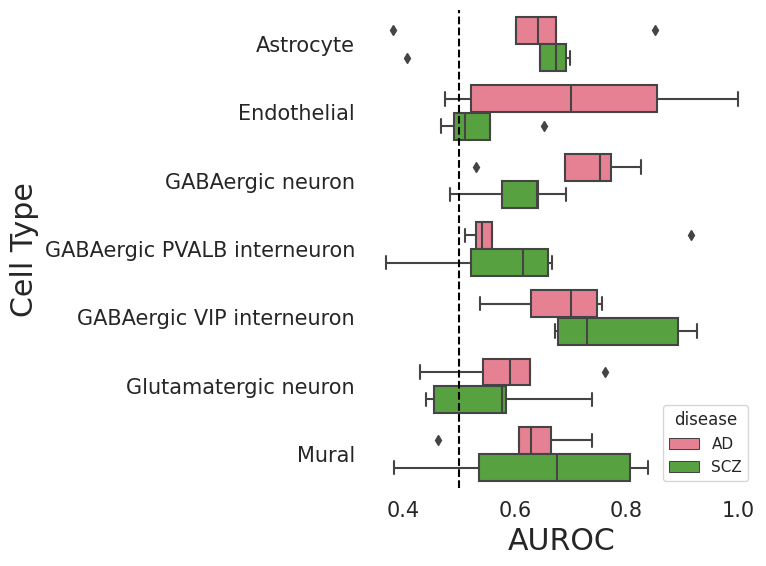

In [38]:
# Load performances
diseases = ['AD', 'SCZ']
auroc_lists = [np.load(f'{get_dirs(d)[1]}/auroc-{runs}-{folds}.npy') for d in diseases]
# Convert to pandas df
df = pd.DataFrame(data={
    'disease': np.concatenate([folds*len(cell_types)*[d] for d in diseases]),
    'cell_type': np.concatenate(len(diseases)*[folds*[ct] for ct in cell_types]),
    'fold': np.concatenate(len(diseases)*[list(range(folds)) for i in cell_types]),
    'auroc': np.concatenate([np.concatenate(al[list(range(al.shape[0])), np.array(al).mean(axis=-1).argmax(axis=-1), :]) for al in auroc_lists]),
})
# Cherry-pick
df = df.iloc[[e not in np.array(cell_types)[[4, 7, 9, 10]] for e in df['cell_type']]]  # Remove cell types
# Style
style = {}

fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
axs = [axs]
# Barplot
sns.boxplot(ax=axs[0], data=df, x='auroc', y='cell_type', hue='disease', **style)
sns.despine(ax=axs[0], left=True, bottom=True)
# sns.boxplot(ax=axs[1], data=df, x='auprc', y='cell_type', **style)
# sns.despine(ax=axs[1], left=False, bottom=True)
# Labels
axs[0].set_xlabel('AUROC')
axs[0].set_ylabel('Cell Type')
axs[0].axvline(x=.5, color='black', linestyle='--')
# axs[1].set_xlabel('AUPRC')
# axs[1].set_ylabel(None)
plt.tight_layout()
# Save figure
plt.savefig(f'{get_dirs("")[1][:-1]}/fig_performance-{runs}-{folds}.png', dpi=300, bbox_inches='tight')

In [16]:
# Load data
auroc_list = np.load(f'{results_dir}/auroc-{runs}-{folds}.npy')

# Predict per cell type
predictions = []
for i, (cell_type, cell_fname) in enumerate(zip(cell_types, cell_fnames)):
    print(f'Running {cell_type} predictions')
    # Get best avg auroc for cell type
    run = auroc_list[i].mean(axis=-1).argmax()
    
    # Get validation predictions from each fold
    for fold in range(folds):
        tg_genes = get_data(cell_fname, directed=directed)
        reg_threshold = filter_elist()
        dim, num_walks, walk_length = dim_list[run], num_walks_list[run], walk_length_list[run]
        genes, labels, emb_pp = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run)
        dataset = generate_dataset(genes, labels, emb_pp, fold, folds, run)
        model = generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, fold, folds, run)
        auroc, pred_raw = evaluate_predictions(model, dataset, labels, results_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, run, fold, folds)
        
        if fold == 0:
            predictions_cell = np.zeros_like(pred_raw[:, 1])
        assert np.sum(np.abs(predictions_cell[dataset.val_mask])) == 0
        predictions_cell[dataset.val_mask] += pred_raw[dataset.val_mask][:, 1].numpy()
        
        # Save predictions
        fname = f'{results_dir}/{model_str}-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{runs}-{folds}-Predictions.txt'
        np.savetxt(fname, np.array([[g, float(p)] for g, p in zip(genes, pred_raw[:, 1])]), fmt='%s %s')
        
    predictions.append(predictions_cell)
    
# Concatenate
# np.array(predictions)  # Sometimes ragged

Running Astrocyte predictions
Running Endothelial predictions


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Running GABAergic neuron predictions
Running GABAergic PVALB interneuron predictions


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Running GABAergic SST interneuron predictions


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Running GABAergic VIP interneuron predictions
Running Glutamatergic neuron predictions
Running Microglia predictions


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Running Mural predictions
Running Oligodendrocyte predictions


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Running OPC predictions


/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [24]:
# ordered_genes = np.loadtxt(f'results/AD/mlp-GABAergic neuron-128-20-10-0-10-5-Predictions.txt', dtype=str)[:, 0]
ordered_genes = np.loadtxt(f'results/SCZ/mlp-GABAergic VIP interneuron-128-40-20-0-10-5-Predictions.txt', dtype=str)[:, 0]
for g in ordered_genes[:int(.1*ordered_genes.shape[0])]:
    print(g)

INSM1
THSD7B
ONECUT1
CNTN5
ETS1
EGFEM1P
IRF8
PRR16
TBR1
ONECUT2
COL21A1
MEF2C
NR2F2
SP8
UNC5D
RXRG
KIRREL3
SOX13
AR
MGAT4C
LEF1
ZIC4
RUNX1T1
ONECUT3
ANXA4
NR3C2
BACH2
TMEM132D
FOXO4
SEMA6D
GRHL2
TSHZ2
POU3F1
ASCL1
SCN9A
TCF4
IL1RAPL2
IRF5
MYO10
PDE1C
TP63
SPOCK1
EGR1
DNAJB1
MAF
HS6ST3
PRKG1
PRDM1
FAT4
PBX3
RARB
ID4
NKAIN2
RGS6
GDA
IRF2
ZIC1
PDZRN3
JUN
DCC
ZBTB7C
SMAD3
GRID2
IRF3
SDC2
FOXP2
NXPH1
PKNOX2
EOMES
ETV6
DPP6
IMMP2L
BHLHE22
RORA
CALN1
ZSCAN4
GRAMD1C
PDE7B
GABRG3
SCRT1
MAFF
ZEB1
PPARG
ANKRD30B
KCNIP4
MAFK
SMOC1
HAVCR2
HNF1B
XBP1
FLI1
CNR1
TBL1X
SNAI2
POU6F2
SLC8A1
NR2F1
TMEM108
CTCFL
SHROOM4
NBPF15
PTH2R
POU2F1
HNF4G
ANO4
RARA
OLFM3
CDH9
NR3C1
SOX8
POU3F2
COBLL1
CDH4
REST
NFIX
NPAS3
NFYA
SPI1
ELF4
ESYT3
CUX1
HTR4
PRKD1
SOX15
CCDC148
CHRNA7
PARD3B
JDP2
SYN3
PTPRT
RORB
RGS5
PTPRD
VAX1
HTR2C
STAT1
UBE3A
GRIA3
IRF1
MAK
AP1S2
NFIA
KLF9
ITPR1
RFTN1
PDE1A
TRPC4


# Visualization

In [18]:
name_map = {'pos': 'Disease', 'neg': 'Not Disease', 'unk': 'Unknown'}
color_map = {'pos': np.array((1, .2, .2)), 'neg': np.array((.2, .2, 1)), 'unk': np.array((0, 0, 0))}
z_map = {'pos': 2, 'neg': 1, 'unk': 0}
s_map = {'pos': 10., 'neg': 1., 'unk': .5}

In [19]:
%%capture
from matplotlib.lines import Line2D

# Legend
legend = [
    Line2D([], [], color=(1, 1, 1, 0), markerfacecolor=color_map[l], marker='o', markersize=10)
    for l in name_map]
legend_names = [name_map[l] for l in name_map]

# Plot legend
fig, ax = plt.subplots()
legend = ax.legend(legend, legend_names, loc='center', frameon=False, ncol=len(legend)//1)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{results_dir}/fig_legend.png', bbox_inches=bbox, dpi=300)

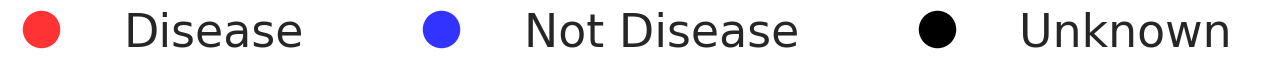

In [20]:
from IPython.display import display, Image
display( Image(filename=f'{results_dir}/fig_legend.png', width=800) )

In [21]:
### Get best model
auroc_list = np.load(f'{results_dir}/auroc-{runs}-{folds}.npy')
ct, run, fold = np.unravel_index(np.argmax(auroc_list), auroc_list.shape)
cell_type, cell_fname = cell_types[ct], cell_fnames[ct]

### Load best model
tg_genes = get_data(cell_fname, directed=directed)
reg_threshold = filter_elist()
dim, num_walks, walk_length = dim_list[run], num_walks_list[run], walk_length_list[run]
genes, labels, emb_pp = get_embeddings_from_elist(model_dir, cell_type, tg_genes, dim, num_walks, walk_length, percentile, run)
dataset = generate_dataset(genes, labels, emb_pp, fold, folds, run)
model = generate_model(model_class, dataset, model_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, fold, folds, run)
auroc, pred_raw = evaluate_predictions(model, dataset, labels, results_dir, model_str, cell_type, dim, num_walks, walk_length, percentile, run, fold, folds)

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


NameError: name 'trans_inv' is not defined

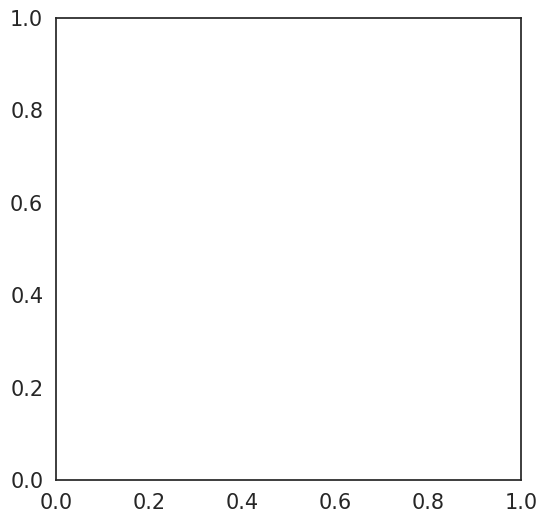

In [22]:
np.random.seed(42)
# submask = torch.tensor((np.random.rand(dataset.x.shape[0]) > .7), dtype=bool)
submask = torch.tensor((np.random.rand(dataset.x.shape[0]) > .4), dtype=bool) * dataset.val_mask
G = tg.utils.to_networkx(dataset.subgraph(np.argwhere(submask).flatten()), node_attrs=['x'], edge_attrs=['edge_weight'], to_undirected=not directed)
edge_color = [(0, 0, 0, .1*G[u][v]['edge_weight'] / float(dataset.subgraph(np.argwhere(submask).flatten()).edge_weight.max())) for u, v in G.edges]
pos = nx.spring_layout(G, weight='edge_weight', k=.5)

# Original Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
node_color = [color_map[trans_inv[int(v)]] for v in dataset.y[submask]]
nx.draw(
    G,
    node_color=node_color,
    edge_color=edge_color,
    node_size=10,
    pos=pos,
)
plt.title('Gene Coregulation')
plt.savefig(f'{results_dir}/fig_data-{runs}-{folds}.png', dpi=300)

# Computed Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# pred = model(dataset).detach().argmax(dim=1)
threshold = pred_raw[dataset.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))
pred = 1*(model(dataset).detach()[:, 1] > threshold)
# Show known
# node_color = [color_map[trans_inv[int(v)]] if v != 2 else color_map[trans_inv[int(w)]] for v, w in zip(dataset.y[submask], pred[submask])]
# Do not show known
# node_color = [color_map[trans_inv[int(v)]] for v in pred[submask]]
# Show spectrum
strong_range = .1
center = .4
min_range, max_range = center - strong_range, center + strong_range
node_color = [
    np.array(
        (1-((max(min(v[1], max_range), min_range) - min_range)/(2*strong_range)))*color_map['neg']
        + ((max(min(v[1], max_range), min_range) - min_range)/(2*strong_range))*color_map['pos']
    )
        for v in pred_raw[submask].exp().numpy()]
node_color = [[max(min(cv, 1), 0) for cv in c] for c in node_color]
nx.draw(
    G,
    node_color=node_color,
    edge_color=edge_color,
    node_size=10,
    pos=pos,
)
plt.title('Predicted Disease')
plt.savefig(f'{results_dir}/fig_prediction-{runs}-{folds}.png', dpi=300)